In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
from scipy import stats

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect, distinct

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
#Inspect Database. Explore tables and columns
Inspector = inspect(engine)
tables = Inspector.get_table_names()

print("-----Tables------")
for table in tables:
    print(f"{table}")
    for column in Inspector.get_columns(table):
        print(column)

-----Tables------
measurement
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
station
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'defau

In [8]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

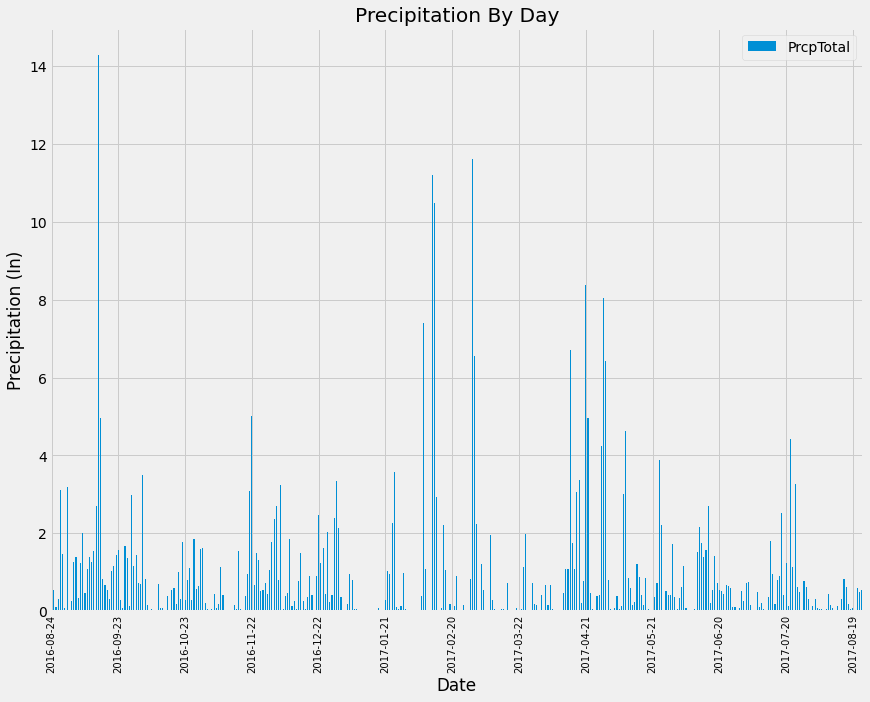

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(func.max(Measurement.date)).first()
twelve_months_prior = dt.datetime.strptime(max_date[0], "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

#Create query to group by month.
sel = [func.strftime("%Y-%m",Measurement.date),
       func.sum(Measurement.prcp)]

precip_by_month = session.query(*sel).\
                  group_by(func.strftime("%Y-%m",Measurement.date)).\
                  filter(Measurement.date >= twelve_months_prior).\
                  order_by(func.strftime("%Y-%m",Measurement.date)).all()

#Create query to pull detail and group at day level                     
sel = [Measurement.date,
       func.sum(Measurement.prcp)]

precip_detail = session.query(*sel).\
                group_by(Measurement.date).\
                filter(Measurement.date >= twelve_months_prior).\
                order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame and set the index to the month column
#DataFrame with precipitation aggregated by month
precip_months_df = pd.DataFrame(precip_by_month,columns=["YearMonth","PrcpTotal"])
precip_months_df.set_index("YearMonth", inplace = True)

#Save the query results as Pandas DataFrame and set the index to date column
#DataFrame with precipitation aggregated by date
precip_detail_df = pd.DataFrame(precip_detail, columns=["Date", "PrcpTotal"])
precip_detail_df.sort_values(by="Date",inplace=True)


# Sort the dataframe by date/month
precip_months_final_df = precip_months_df.sort_values(by="YearMonth").tail(12)
precip_detail_final_df = precip_detail_df.sort_values(by="Date")
precip_detail_final_df = precip_detail_final_df.set_index("Date")

# Use Pandas Plotting with Matplotlib to plot the data

#Plot By Day


ax1 = precip_detail_final_df.plot.bar(figsize=(12,10))

#Plot Daily Precipitation
#reduce ticks for detail graph. Skip every 30 days
n=30
ax1.get_xticks()[::n]
#ax1.get_xticks()
#ax1.get_xticklabels()
ax1.set_xticks(ax1.get_xticks()[::n])
#ax1.set_xticklabels()
plt.tight_layout()
plt.xlabel("Date")
plt.xticks(fontsize=10)
plt.ylabel("Precipitation (In)")
plt.title("Precipitation By Day")
plt.savefig("Images/precip_by_day.png")
plt.show()


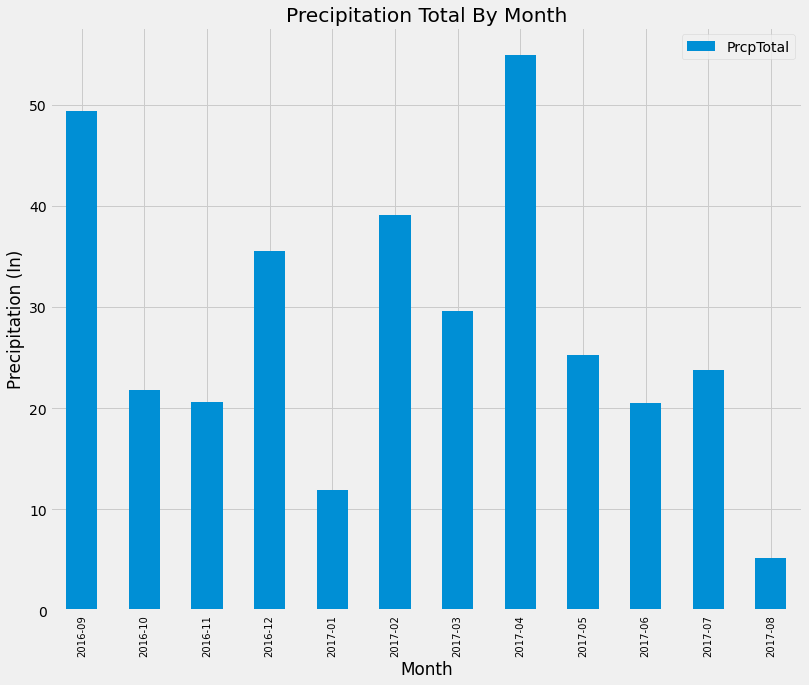

In [25]:
#Plot Precipiation By Month
precip_months_final_df.plot.bar(figsize=(12,10))
plt.xlabel("Month")
plt.xticks(fontsize=10)
plt.ylabel("Precipitation (In)")
plt.title("Precipitation Total By Month")
plt.savefig("Images/precip_by_month.png")
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data (daily detail)

prcp_mode = precip_detail_df["PrcpTotal"].mode()
prcp_mean = precip_detail_df["PrcpTotal"].mean()
prcp_median = precip_detail_df["PrcpTotal"].median()
prcp_stddev = precip_detail_df["PrcpTotal"].std()
quartiles = precip_detail_df["PrcpTotal"].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq
lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)

outliers = precip_detail_df.loc[(precip_detail_df["PrcpTotal"] <= lower_bound) | (precip_detail_df["PrcpTotal"] >= upper_bound),["PrcpTotal","Date"]]

print(f"Mode: {prcp_mode[0]}")
print(f"Mean: {prcp_mean}")
print(f"Median {prcp_median}")
print(f"Standard Deviation: {prcp_stddev}")
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")



Mode: 0.0
Mean: 0.9741643835616438
Median 0.39999999999999997
Standard Deviation: 1.7764658628622152
Values below -1.4949999999999999 could be outliers.
Values above 2.625 could be outliers.


In [15]:
#Generate Outlier List identified in above cell
outliers[["Date","PrcpTotal"]].set_index("Date")

,PrcpTotal
Date,
2016-08-24,9.33
2016-08-28,3.10
2016-08-31,3.18
2016-09-13,2.71
2016-09-14,14.28
2016-09-15,4.96
2016-09-29,2.99
2016-10-04,3.49
2016-11-21,3.08


In [16]:
# Design a query to show how many stations are available in this dataset?
stations_all = session.query(func.count(distinct(Station.station))).first()
                             
stations_with_measurements = session.query(func.count(distinct(Measurement.station))).first()

print(f"Total stations: {stations_all[0]}, Stations with measurments: {stations_with_measurements[0]}")


Total stations: 9, Stations with measurments: 9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [Measurement.station,
       func.count()]

station_most_active_qry = session.query(*sel).\
                           group_by(Measurement.station).\
                           order_by(func.count().desc()).all()
station_most_active_df = pd.DataFrame(station_most_active_qry,columns=["station","observations"])

station_most_active_df

,station,observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_most_active = station_most_active_df.iloc[0,0]

sel = [Measurement.station,
       func.min(Measurement.prcp),
       func.max(Measurement.prcp),
       func.avg(Measurement.prcp)]
station_stats = session.query(*sel).\
                        filter(Measurement.station == station_most_active).\
                         group_by(Measurement.station).first()

print(f"Station: {station_stats[0]} precipiation stats - Min: {station_stats[1]} Max: {station_stats[2]} Avg: {round(station_stats[3],3)}")

Station: USC00519281 precipiation stats - Min: 0.0 Max: 9.64 Avg: 0.212


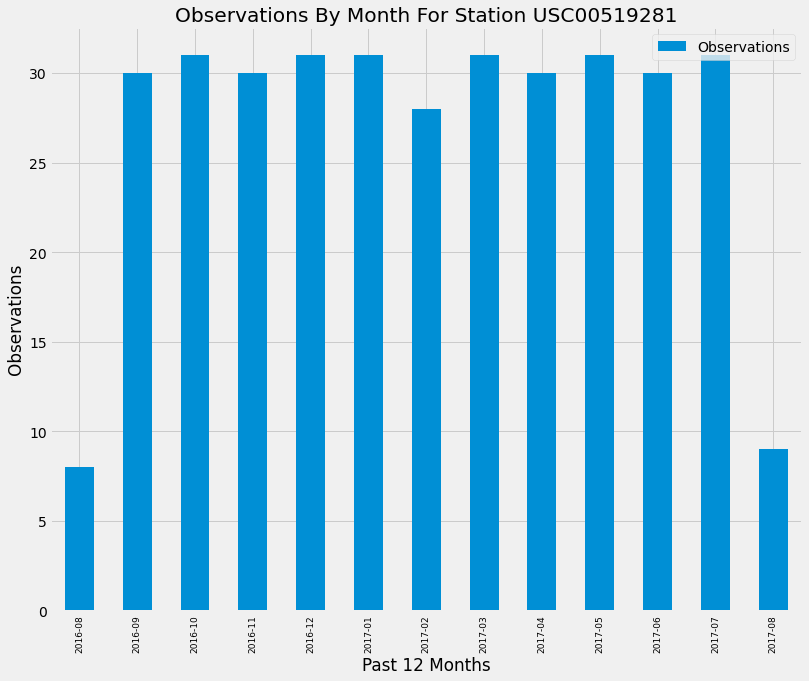

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel = [func.strftime("%Y-%m",Measurement.date),
       func.count()]

obs_by_month = session.query(*sel).\
                  group_by(func.strftime("%Y-%m",Measurement.date)).\
                  filter(Measurement.date >= twelve_months_prior, Measurement.station == station_most_active).\
                  order_by(func.strftime("%Y-%m",Measurement.date)).all()

obs_by_month_df = pd.DataFrame(obs_by_month,columns=["YearMonth","Observations"])
obs_by_month_df.sort_values(by="YearMonth",inplace=True)
obs_by_month_df.set_index("YearMonth",inplace=True)
obs_by_month_df.plot.bar(figsize=(12,10))

plt.title(f"Observations By Month For Station {station_most_active}")
plt.xticks(fontsize=9)
plt.xlabel("Past 12 Months")
plt.ylabel("Observations")
plt.savefig("Images/most_active_station_obs.png")
plt.show()


## Bonus Challenge Assignment

## Temperature 1 Analysis

In [176]:
#Load Pandas tables:
measurements_df = pd.read_csv("Resources/hawaii_measurements.csv")

#Create new column with date value converted to date/time
measurements_df["date_calc"] = pd.to_datetime(measurements_df["date"])
measurements_df["month"] =  measurements_df["date_calc"].dt.month

#Group by Station, month for June and Decemenber months only
measurements_jun_dec_df = measurements_df[(measurements_df["month"] == 6) | (measurements_df["month"] == 12)]
measurements_jun_dec_df
measurements_jun_dec_group_df = measurements_jun_dec_df.groupby(by = ["station","month"])["tobs"].mean().reset_index()

#Pivot Dataframe to prepare temperature measurements for paired T test. Station's June average temperature versus Decemenber.
#Observations are compared from the same population (stations). Use a pivot table on station to prepare data for T Test.
measurements_jun_dec_group_df = measurements_jun_dec_group_df.pivot(index="station",columns="month",values="tobs")
measurements_jun_dec_group_df.reset_index(inplace = True)

measurements_jun_dec_group_df.columns = ["staion","jun","dec"]

measurements_jun_dec_group_df

,staion,jun,dec
0,USC00511918,74.139394,69.684211
1,USC00513117,74.050847,71.069444
2,USC00514830,76.005376,73.224719
3,USC00516128,71.937220,69.291262
4,USC00517948,76.655405,71.834862
5,USC00518838,73.394737,72.421053
6,USC00519281,73.271186,69.903226
7,USC00519397,77.559322,71.109524
8,USC00519523,76.668103,72.433333


### Paired T Test
Time based results from the same population are being studied to determine if the month of the year significantly impacts temperature.  Since the same population of stations are being used and we're comparing paired observation outcomes using a paired T test is appropriate.

**H<sub>O**: There is no significant difference between June and December average temperature
    
**H<sub>A**: There is a significatn difference between Jane and December average temperatures

In [177]:
#Using a paired T Test 
measurements_jun_dec_group_df["jun"]
tStat, pValue =  stats.ttest_rel(measurements_jun_dec_group_df["jun"], measurements_jun_dec_group_df["dec"])
print("P-Value:{0} T-Statistic:{1}".format(pValue,tStat)) #print the P-Value and the T-Statisti

P-Value:0.00011759380231523222 T-Statistic:6.95696617044294


### Results 
With P-Value of.00012 and less than .05 we can reject the null hypothesis and report that there is sufficient evidence that the average temperature of the month and June and December is different.